# PYMC calculations for Bayes
Using https://www.pymc.io/ for Ab tests bayes calculations
* Done with the conversion calculations
* TBD with RPU calculations


---

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns
import arviz as az
import pymc as pm

In [ ]:
# Assume 10 trials and 5 successes out of those trials
# Change these numbers to see how the posterior plot changes
trials = 10; successes = 5

# Set up model context
with pm.Model() as coin_flip_model:
    # Probability p of success we want to estimate
    # and assign Beta prior
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Define likelihood
    obs = pm.Binomial("obs", p=p, n=trials,
        observed=successes,
    )

    # Hit Inference Button
    idata = pm.sample()

az.plot_posterior(idata, show=True);

In [40]:
class Calculations(object):
    def __init__(self, visitors_A, conversions_A, visitors_B, conversions_B, test_duration, percent_traffic_in_test, aov, min_rev_yield):
        self.visitors_A = visitors_A
        self.conversions_A = conversions_A
        self.visitors_B = visitors_B
        self.conversions_B = conversions_B
        self.control_cr = conversions_A / visitors_A
        self.variant_cr = conversions_B / visitors_B
        self.relative_difference = self.variant_cr / self.control_cr - 1
        self.test_duration = test_duration
        self.percent_traffic_in_test = percent_traffic_in_test
        self.min_rev_yield = min_rev_yield
        self.aov = aov
        
    def generate_posterior_samples(self):
        
        alpha_prior = 1
        beta_prior = 1
        samples = 50000
        chains = 4
        draws = int(samples / chains)

        # Set up model context
        with pm.Model() as bayes_ab_model:
            p = pm.Beta("p",   alpha=alpha_prior, beta=beta_prior)
            obs = pm.Binomial("obs",   p=p, n=self.visitors_A,observed=self.conversions_A,)
            idata1 =  pm.sample(draws=draws, chains=chains, discard_tuned_samples=False)
            i1 = idata1['posterior']['p']
            a1 = np.reshape(i1, (i1.size,1))
            self.samples_posterior_A =  np.array(a1[:,0])
        
        with pm.Model() as bayes_ab_model_2:
            p = pm.Beta("p", alpha=alpha_prior, beta=beta_prior)
            obs = pm.Binomial("obs", p=p, n=self.visitors_B,observed=self.conversions_B,)
            idata2 =  pm.sample(draws=draws, chains=chains, discard_tuned_samples=False)
            i2 = idata2['posterior']['p']
            a2 = np.reshape(i2, (i2.size,1))
            self.samples_posterior_B =  np.array(a2[:,0])


    def calculate_probabilities(self):
        """Calculate the likelihood that the variants are better"""

        self.prob_A = (self.samples_posterior_A > self.samples_posterior_B).mean()
        self.prob_B = (self.samples_posterior_A <= self.samples_posterior_B).mean()
        
        #relative difference not absolute
        difference = self.samples_posterior_B / self.samples_posterior_A - 1
        self.greater = difference[difference > 0]
        self.lower = difference[difference < 0]
        
        self.mean_positive_difference = 0 if self.greater.size == 0 else self.greater.mean()
        self.mean_negative_difference = 0 if self.lower.size == 0 else self.lower.mean()

        six_months_in_days = 182.5
        visitors_in_six_months = (self.visitors_A + self.visitors_B) / (self.percent_traffic_in_test / 100) / self.test_duration * six_months_in_days
        revenue_in_six_months = visitors_in_six_months * self.control_cr * self.aov 
        
        self.expected_risk = revenue_in_six_months * self.mean_negative_difference
        self.expected_uplift = revenue_in_six_months * self.mean_positive_difference
        min_uplift_prob = self.min_rev_yield / revenue_in_six_months 
        self.prob_yield_mean = (difference >= min_uplift_prob).mean()
        
        self.total_contribution = self.expected_risk * self.prob_A + self.expected_uplift * self.prob_B


In [41]:
#b = Calculations(visitors_A, conversions_A, visitors_B, conversions_B, test_duration, traffic_test, aov, min_rev_yield)
bayes = Calculations(5000, 1500, 5000, 1600, 14, 100, 100, 5000)
bayes.generate_posterior_samples()
bayes.calculate_probabilities()
print("CR A:", f"{bayes.control_cr:.2%}", ", CR B:", f"{bayes.variant_cr:.2%}", ", relative difference:", f"{bayes.relative_difference:.2%}") 
print("Chance of being worse", f"{bayes.prob_A:.2%}", "chance of being best", f"{bayes.prob_B:.2%}")
print("Mean negative difference", f"{bayes.mean_negative_difference:.2%}", ", mean positive difference",f"{bayes.mean_positive_difference:.2%}")
print("Expected risk", f"{bayes.expected_risk:,.0f}", ", expected uplift", int(bayes.expected_uplift), ", total contribution", int(bayes.total_contribution))
print("Chance of at least", bayes.min_rev_yield,"in extra revenue:", round(bayes.prob_yield_mean*100,2),"%")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 12_500 draw iterations (4_000 + 50_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 12_500 draw iterations (4_000 + 50_000 draws total) took 2 seconds.


CR A: 30.00% , CR B: 32.00% , relative difference: 6.67%
Chance of being worse 1.51% chance of being best 98.49%
Mean negative difference -1.01% , mean positive difference 6.81%
Expected risk -39,396 , expected uplift 266370 , total contribution 261759
Chance of at least 5000 in extra revenue: 98.31 %


[0.29914326 0.29060798 0.29060798 ... 0.29498933 0.29498933 0.29498933]


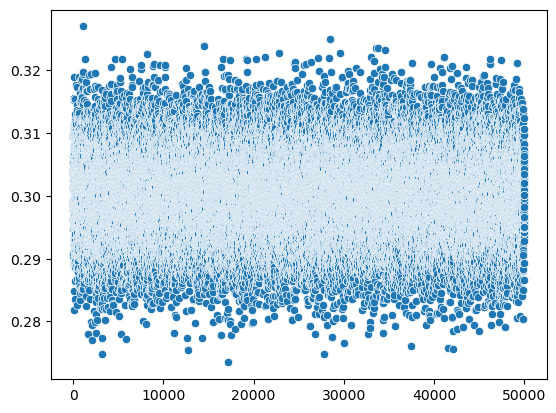

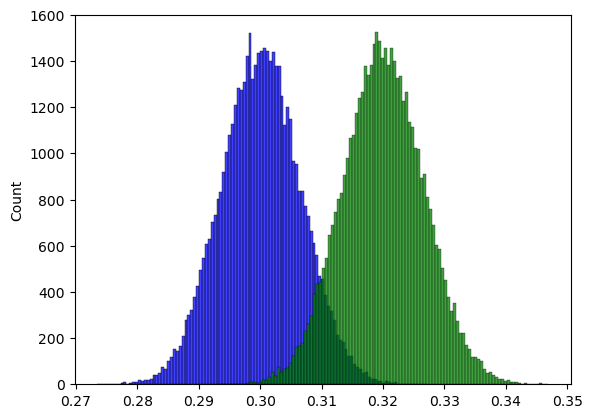

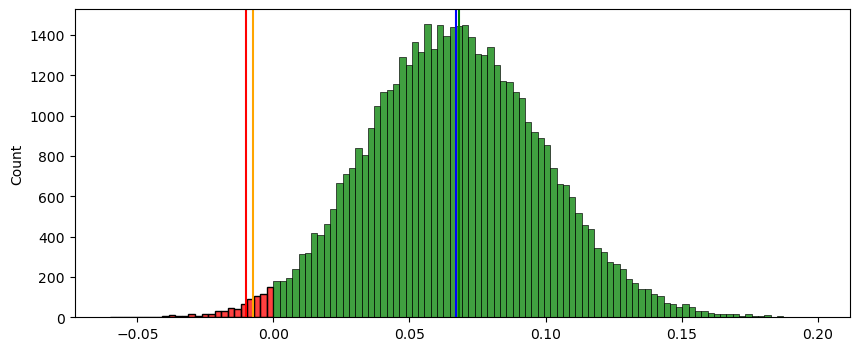

In [42]:
print(bayes.samples_posterior_A)
sns.scatterplot(bayes.samples_posterior_A)
plt.show()

sns.histplot(bayes.samples_posterior_A, color="blue")
sns.histplot(bayes.samples_posterior_B, color="green")
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.patch.set_alpha(0.8)
sns.histplot(bayes.lower, color="red")
sns.histplot(bayes.greater, color="green")
ax.axvline(x = bayes.lower.mean(), color = 'red')
ax.axvline(x = np.median(bayes.lower), color = 'orange')
ax.axvline(x = bayes.greater.mean(), color = 'green')
ax.axvline(x = np.median(bayes.greater), color = 'blue')
plt.show()